In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Softmax regression for handwritten digits

Today, we'll implement a softmax classifier recognizing handwritten digits.  We'll begin by using a relatively small
collection (around 1800) of low resolution (8 by 8pix) digits.  This can be easily acquired using scikit-learn.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

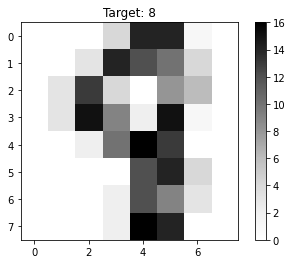

In [3]:
data = digits.data
random_digit = np.random.randint(low=0, high=1797, size=1)[0]
plt.imshow(data[random_digit, :].reshape(8, 8), cmap='Greys')
plt.colorbar()
plt.title(f'Target: {digits.target[random_digit]}')
plt.show()

The digits appear as an $m\times n$ array, where $m$ is the number of data instances and $n$ is the number of features.
It's important to recognize that for this problem, the number of features is $8\times8 = 64$: the instances are
flattened.  If you want to plot a digit from the dataset using, for example, matplotlib's imshow, you'll need to reshape
this.

You'll also want to be careful to normalize the data, preferably by subtracting the mean and dividing by the standard
deviation.

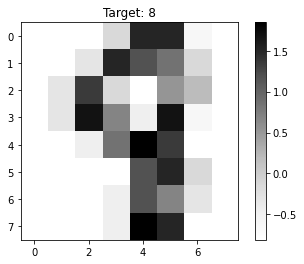

In [4]:
#! Perform normalization
norm_data = ((data - data.mean()) / data.std())
plt.imshow(norm_data[random_digit, :].reshape(8, 8), cmap='Greys')
plt.colorbar()
plt.title(f'Target: {digits.target[random_digit]}')
plt.show()

The labels appear as integers.  Write and apply a function that converts from this integer representation to a one-hot
encoding.

In [5]:
#! Convert the labels to a one-hot encoding
# Create an 1797 x 10 array to hold each digit's encoding
encoding = np.zeros([digits.target.size, digits.target_names.size])

# Loop over each image
for i in range(digits.target.size):
    encode_vec = np.zeros(digits.target_names.size)
    t = digits.target[i]
    encode_vec[digits.target_names[t]] = 1
    encoding[i] = encode_vec


Another important step is to split the dataset into training and testing sets.
I like using the function sklearn.model_selection.train_test_split

In [6]:
#! Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(norm_data, encoding, test_size=0.25, random_state=42)

With data in hand, we now need to implement the model.  Recall that our predictions will be computed as

$$Y_{pred} = \mathrm{Softmax}(\Phi W)$$

Implement the softmax method, generate the matrix $\Phi$ (I suggest a linear model, which is to say that all you need to
do will be to prepend a column of ones to the $m\times n$ matrix of pixel values, and instantiate the parameter matrix
$W$ (I suggest instantiating to an array of very small random numbers).  Your implementation of Softmax should be
vectorized, in that it should take a $m \times N$ array of logits and output and $m \times N$ array without using a
loop.  Make a prediction using this untrained model: a sensible result at this stage is that all classes are
approximately equally likely.

In [7]:
def generate_phi(X, d=1):
    phi_matrix = np.column_stack([np.ones(X.shape[0]), X])
    return phi_matrix

phi = generate_phi(X_train)
w = np.random.random([phi.shape[1], digits.target_names.size]) * 1e-2

def softmax(phi_a, w_a):
    z = phi_a @ w_a
    numerator = np.exp(z)
    denominator = np.sum(np.exp(z), axis=1)
    return numerator / denominator.reshape(-1, 1)

Y_pred = softmax(phi, w)
print(Y_pred)
test = np.sum(Y_pred, axis=1)
print(test)

[[0.10054413 0.10371774 0.10379176 ... 0.09872093 0.09697856 0.09353213]
 [0.10254341 0.10342875 0.10321274 ... 0.09848305 0.0989233  0.09820942]
 [0.1002213  0.10242716 0.10214435 ... 0.09769752 0.09964008 0.09843964]
 ...
 [0.09969939 0.10341006 0.10268457 ... 0.09788404 0.09601761 0.1010034 ]
 [0.10215857 0.10459341 0.10399113 ... 0.09859429 0.09641772 0.09802602]
 [0.10289906 0.10407062 0.10403056 ... 0.09815424 0.098799   0.09928141]]
[1. 1. 1. ... 1. 1. 1.]


Now generate functions (or one function with multiple outputs) to compute the categorical cross entropy and its
gradient.  These are given by

$$\mathcal{L}(W,\Phi,Y_{obs}) = -\frac{1}{mN} \sum_{i=1}^m \left(Y_{obs,i} \ln \mathrm{Softmax}(\Phi W)\right).$$

and

$$\frac{ \partial \mathcal{L}}{\partial W} = -\frac{1}{mN} \sum_{i=1}^m \left[(Y_{obs,i} - \mathrm{Softmax}(\Phi W)_i) \Phi_i^T\right]^T. $$

As you implement these functions, consider how to do so in as efficient a manner as possible.
Note that it is possible to vectorize the sums.

In [15]:
def L_func(Y_obs, phi_f, w_f):
    inside = np.sum(Y_obs * np.log(softmax(phi_f, w_f)), axis=0)
    return -inside / Y_obs.shape[0] / Y_obs.shape[1]

def L_grad(Y_obs, phi_f, w_f):
    S = softmax(phi_f, w_f)
    first = np.transpose(Y_obs - S)
    return -np.transpose(first @ phi_f) / Y_obs.shape[0] / Y_obs.shape[1]

L = L_func(Y_train, phi, w)
print(L)
lgrad = L_grad(Y_train, phi, w)
print(lgrad.shape, w.shape)

[0.00017373 0.00016859 0.00017078 ... 0.00016898 0.00017199 0.00016798]
(65, 10) (65, 10)


Implement gradient descent and train this model.  Record the value of $\mathcal{L}$ as a function of gradient descent
iteration, and produce a plot convincing yourself that the model is converging to a minimum.

1383it [00:00, 1674.61it/s]

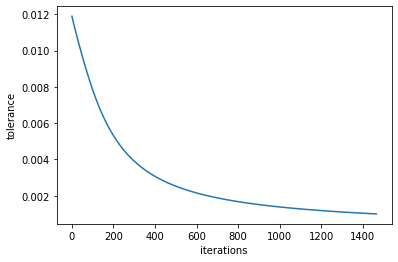

Current tol: 0.0009198710472481462: 1620it [02:30, 10.74it/s] 


In [27]:
def gradient_descent(grad, Y_obs, phi_f, guess, eta=1e-3, tol=1e-6, pbar=None):
    """
    grad - gradient function
    w0 - initial guess (nx1 vector)
    eta - step size
    tol - convergence tolerance
    """
    tol_list = []
    current_tol = 100
    w_curr = guess
    iters = 0
    while current_tol > tol:
        gradient = grad(Y_obs, phi_f, w_curr)
        w_new = w_curr - eta * gradient
        current_tol = np.linalg.norm(np.abs(w_new - w_curr))
        tol_list.append(current_tol)
        w_curr = w_new
        pbar.update(1)
        iters += 1
        if iters % 3000 == 0:
            pbar.set_description_str(f'Current tol: {current_tol}')
    return w_curr, tol_list

tol_log = tqdm.tqdm(position=0)
w_best, tolerance_over_time = gradient_descent(L_grad, Y_train, phi, w, eta=1e-1, tol=1e-3, pbar=tol_log)
plt.plot(tolerance_over_time)
plt.xlabel('iterations')
plt.ylabel('tolerance')
plt.show()

One very interesting result of working with image data is that we can interpret the learned parameters as images (the weight matrix is $N\times (1+n)$.  If you get rid of the first entry, which corresponds to a constant offset, the remaining $N \times n$ weights are each associated with a given input pixel for a given class).  Plot your weights as images (there should be ten of them).  Evaluate the pattern that you find.    

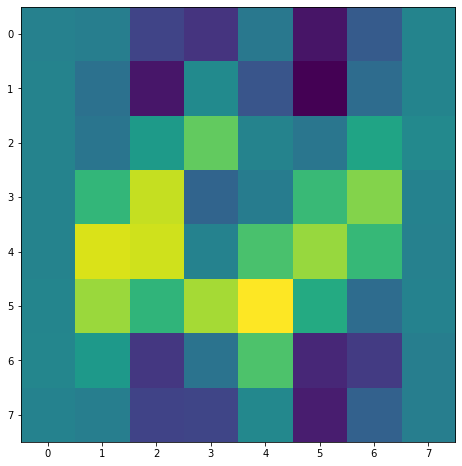

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(w_best[1:, 4].reshape(8, 8))
plt.show()

In [11]:
phi_test = generate_phi(X_test)
Y_pred = softmax(phi_test, w_best)

m = Y_test.shape[0]
successes = 0
for i in range(Y_test.shape[0]-1):
    guess = np.argmax(Y_pred[i, :])
    target = np.argmax(Y_test[i, :])
    if guess == target:
        successes += 1
print(f'Got {successes / m * 100:.2f}% correct')

Got 95.11% correct


Current tol: 0.000999700854473081: 1466it [00:20, 315.16it/s]

Finally, once this task is complete, scale your method up to the larger (in both number of instances and resolution) dataset MNIST (you can get it using the command sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)).  This will take substantial time to train!  Only do this once you are satisfied with your implementation on the digits dataset.  

In [21]:
import sklearn
mnist = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1091)>

In [22]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1091)>